### Balance data 

In [4]:
import pandas as pd
import numpy as np
import re
import pickle

In [9]:
# load file
filePath = "../../"
rev = pd.read_csv(filePath+"reviews.csv")
rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin & Christi,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,344,79805581,2016-06-14,2089550,Drew & Katie,We really enjoyed our stay here in Burbank! Th...
3,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...
4,344,315417394,2018-08-28,208896709,Lauren,My family had a wonderful stay at Melissa’s ho...


In [147]:
rev2 = rev.dropna()['comments'] # clean NA
rev2.head()

NameError: name 'rev' is not defined

### First, try balance buy sentimental score

In [55]:
# use textblob to find sentimental scores

from textblob import TextBlob

senti_score = [(TextBlob(w).sentiment.polarity) for w in rev2]
senti_score

[0.0,
 0.3566666666666667,
 0.4578863636363636,
 0.0,
 0.5397354497354496,
 0.6666666666666666,
 0.4741391941391942,
 0.31428571428571433,
 0.48095238095238096,
 0.44999999999999996,
 0.0,
 0.39444444444444443,
 0.47239583333333335,
 0.44119047619047613,
 0.6416666666666666,
 0.46448863636363635,
 0.2943181818181818,
 0.5017482517482518,
 0.6594444444444444,
 0.01024531024531024,
 0.45142857142857146,
 0.27785714285714286,
 0.3870179063360882,
 0.338370720188902,
 0.24236111111111114,
 0.6690476190476191,
 0.4871111111111111,
 0.5007575757575757,
 0.6116666666666666,
 0.446969696969697,
 0.24634548611111112,
 0.25684974747474754,
 0.0,
 0.5174399181547619,
 0.14728835978835977,
 0.6833333333333332,
 0.2,
 0.25,
 0.60625,
 0.31666666666666665,
 0.3333333333333333,
 1.0,
 0.09346326164874554,
 0.40625,
 0.325,
 0.9,
 0.32129629629629636,
 0.8500000000000001,
 0.016984126984126994,
 -0.45,
 -0.14666666666666667,
 0.525,
 0.5708333333333333,
 0.17179487179487188,
 0.24,
 0.5523809523809523

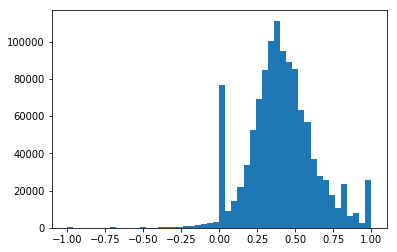

In [58]:
#  see distribution

import matplotlib.pyplot as plt
plt.hist(senti_score, range = (-1,1), bins = 50)
rev = pd.DataFrame(rev.dropna())
rev['sentiment'] = senti_score

In [72]:
# dump sentimental file

path = "./review_sentimental.pickle"
pickle.dump( rev2, open(  path, "wb") )

In [64]:
rev[rev['sentiment']<=0.1].head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,109,449036,2011-08-15,927861,Edwin & Christi,The host canceled my reservation the day befor...,0.000000
3,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...,0.000000
10,2708,222420570,2017-12-29,155985882,Manami,ホストはとても親切で英語の発音の仕方など丁寧に教えてくれた。\n\n部屋はリビングを板で仕切...,0.000000
19,2732,549063,2011-09-19,1131391,Connie,The bed is a pull out loveseat in the ground l...,0.010245
32,2732,126673997,2017-01-13,105697316,Eva,Havde en fantastisk tid hos Yoga Priestess. Et...,0.000000


#### most review of 0 sentiment score is something that the model or current lexicon can't interpret. So we should remove that out

### Resampling the negative review & remove some positive review

In [82]:
# clean 0 one out since it doesn't provide us more information and most of them are foreign language reviews or automatic host cancellation warning

print(len(rev))

rev_neg = rev[rev['sentiment']<0]
rev_pos = rev[rev['sentiment']>0]

In [100]:
# remove some positive
np.random.seed(10)


# undersampling
rev_pos_dropped =rev_pos.drop(np.random.choice(rev_pos.index, 500000, replace=False))
print(len(rev_pos))
print(len(rev_pos_dropped))
print(len(rev_neg))

1076564
576564
13929


In [115]:
rev_neg.iloc[5]['comments']
# 100000/500000

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
49,3021,125059485,2017-01-03,103591276,Frederic,"Quartier charmant, vert et au calme sans être ...",-0.450000
50,3021,180533648,2017-08-10,18821733,Davinia,"very unreliable host, \n\nWasn't helpful I fo...",-0.146667
142,5728,149964877,2017-05-06,17930339,Lucienne,Die Lage vom tiny house ist super und man komm...,-0.122222
177,5728,200010748,2017-10-03,34778175,Maria,I came to Sanni's property emotionally exhaust...,-0.120000
297,5729,186843457,2017-08-25,143553312,Joey,Cribb (Phone number hidden by Airbnb),-0.166667


In [404]:
# resampling data with some modification 
# Since we want our data to be diverse. We modify the last sentence 

def resampling(sentence):
    sp = str(sentence[5]).split('.')
    s = '.'.join(sp[0:-2])
    s = sp[0:-1]
    dummy = pd.DataFrame([
        "it can be a little sketchy.",
        "The area is not what I expected, probably not the safest place to walk at night.",
        "The neighborhood was scary and the building didn't really have good vibes. ",
        "Pretty sketchy/dodgy area. ",
        "If without considering the hygiene and safety of surrounding, it is cheap enough for a swift visit.",
        "There aren’t pictures of the outside of the unit which is very sketchy.",
        "The outside may make you have a second thought but the inside was so stylish and comfy.",
        "The neighborhood is not the greatest but you have the Metro just nearby.",
        "House is in a good neighborhood but you walk across the street and you need to be on high alert."
    ])
    if len(s) >= 2:

        newrev = pd.DataFrame( s[0] + '. ' + np.append(np.array(sp[-2]),dummy)).reindex()
        newdf =  pd.DataFrame([sentence]*10)
        newdf = newdf.set_index(newrev.index)
        newdf[5] = newrev
    else:
        newrev = pd.DataFrame( sentence[5] + '. ' + np.append([''],dummy)).reindex()
        newdf =  pd.DataFrame([sentence]*10)
        newdf = newdf.set_index(newrev.index)
        newdf[5] = newrev
    return newdf
    


In [412]:
# merge 

resamp = pd.concat([resampling(s) for s in np.array(rev_neg)])

In [414]:
resamp.columns = rev_neg.columns
resamp.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,3021,125059485,2017-01-03,103591276,Frederic,"Quartier charmant, vert et au calme sans être excentré. \r\nQuant à notre message à notre départ, il ne nous a jamais répondu",-0.45
1,3021,125059485,2017-01-03,103591276,Frederic,"Quartier charmant, vert et au calme sans être excentré. it can be a little sketchy.",-0.45
2,3021,125059485,2017-01-03,103591276,Frederic,"Quartier charmant, vert et au calme sans être excentré. The area is not what I expected, probably not the safest place to walk at night.",-0.45
3,3021,125059485,2017-01-03,103591276,Frederic,"Quartier charmant, vert et au calme sans être excentré. The neighborhood was scary and the building didn't really have good vibes.",-0.45
4,3021,125059485,2017-01-03,103591276,Frederic,"Quartier charmant, vert et au calme sans être excentré. Pretty sketchy/dodgy area, located in a gated area right across from a marijuana dispensary.",-0.45


139290


(array([2.6300e+02, 1.6000e+01, 3.9000e+01, 2.2000e+01, 4.0000e+00,
        7.2000e+01, 8.2000e+01, 2.3100e+02, 7.8000e+01, 5.6000e+01,
        6.2300e+02, 5.7300e+02, 4.8400e+02, 5.7600e+02, 4.1000e+02,
        1.0160e+03, 1.0060e+03, 1.2930e+03, 2.0390e+03, 2.8870e+03,
        6.8330e+03, 6.5520e+03, 9.4790e+03, 7.8280e+03, 6.8100e+03,
        1.5432e+04, 1.6708e+04, 1.9623e+04, 2.1747e+04, 2.5905e+04,
        3.6783e+04, 4.4145e+04, 4.8566e+04, 5.6370e+04, 6.1432e+04,
        5.5481e+04, 4.9064e+04, 4.6772e+04, 3.4300e+04, 3.0650e+04,
        2.0122e+04, 1.5081e+04, 1.4056e+04, 9.5880e+03, 5.7130e+03,
        1.2867e+04, 3.5140e+03, 4.5180e+03, 1.5150e+03, 1.6630e+04]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56

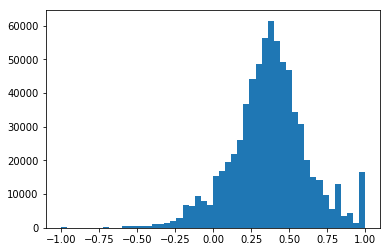

In [418]:
# merge
print(len(resamp))
rev_balance = rev_pos_dropped.append(resamp)
plt.hist([(TextBlob(w).sentiment.polarity) for w in rev_balance['comments']], range = (-1,1), bins = 50)



In [417]:
# save

path = "./review_balance.pickle"
pickle.dump( rev_balance, open(  path, "wb") )

In [77]:
neigh_balance[neigh_balance['sentiment']<=0.01]

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
5014,25670,246670656,2018-03-25,90716304,Darcy,Sandra's place is centrally located and easy t...,5.952381e-03
5978,31939,25526312,2015-01-18,25817412,Huynh,JK has 3 rooms. And my room different photo in...,7.272727e-03
6029,31939,98359133,2016-08-30,81024539,Jiselle,This was my first AirBnb experience so I do no...,9.074074e-03
7388,42165,24110141,2014-12-20,23683033,Shiho,It is a good time to stay in your house but it...,3.125000e-03
10735,53125,39818598,2015-07-26,37342698,Nicole,I really want to leave good feedback because S...,8.333333e-03
16008,84788,116464843,2016-11-30,4817364,Alexander,Pros: Dawn was sweet to offer an extra blanket...,2.500000e-03
16464,87284,96376250,2016-08-22,76864024,Laura,Shortcuts show. Doorknobs were hanging by a th...,2.089434e-03
17028,93359,14389127,2014-06-18,13362932,Carol,Silvio was somewhat helpful. The location was ...,8.134921e-03
17706,100074,225497487,2018-01-06,161991111,Chris,The Location is really all you need to know if...,6.250000e-03
19998,130915,294226967,2018-07-21,32234891,Sarah,Jeff was very accommodating and welcomed us in...,3.333333e-03
